In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=823912e882ebc939ccbafaec499ffac7e3c3657ad95ae219eda7a96d2a88e876
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.decomposition import PCA

In [21]:
# Step 1: Data Collection
nasdaq = yf.download('^IXIC', start="2015-01-01", end="2023-01-01")
SnP = yf.download('^GSPC', start="2015-01-01", end="2023-01-01")
DowJones = yf.download('^DJI', start="2015-01-01", end="2023-01-01")

# Flatten MultiIndex columns if present
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = ['_'.join(col).strip() for col in nasdaq.columns.values]
if isinstance(SnP.columns, pd.MultiIndex):
    SnP.columns = ['_'.join(col).strip() for col in SnP.columns.values]
if isinstance(DowJones.columns, pd.MultiIndex):
    DowJones.columns = ['_'.join(col).strip() for col in DowJones.columns.values]

# # Create binary target: 1 if next day's Close > today's Close, else 0
nasdaq['Target'] = nasdaq['Close_^IXIC'].rolling(window=5, min_periods=1).mean().shift(-5)
SnP['Target'] = SnP['Close_^GSPC'].rolling(window=5, min_periods=1).mean().shift(-5)
DowJones['Target'] = DowJones['Close_^DJI'].rolling(window=5, min_periods=1).mean().shift(-5)

# Drop rows with NaN values caused by rolling/shift operations
nasdaq.dropna(inplace=True)
SnP.dropna(inplace=True)
DowJones.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
close_prices = nasdaq['Close_^IXIC']
# close_prices = SnP['Close_^GSPC']
# close_prices = DowJones['Close_^DJI']

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ADF Statistic: -1.076963
p-value: 0.724171


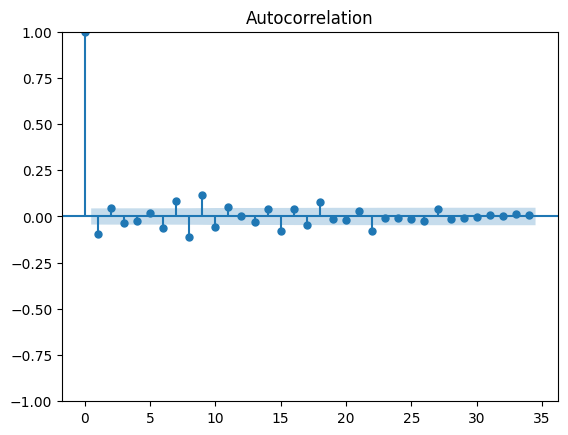

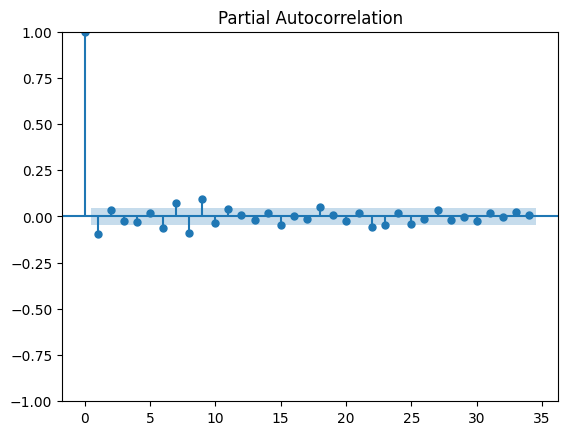

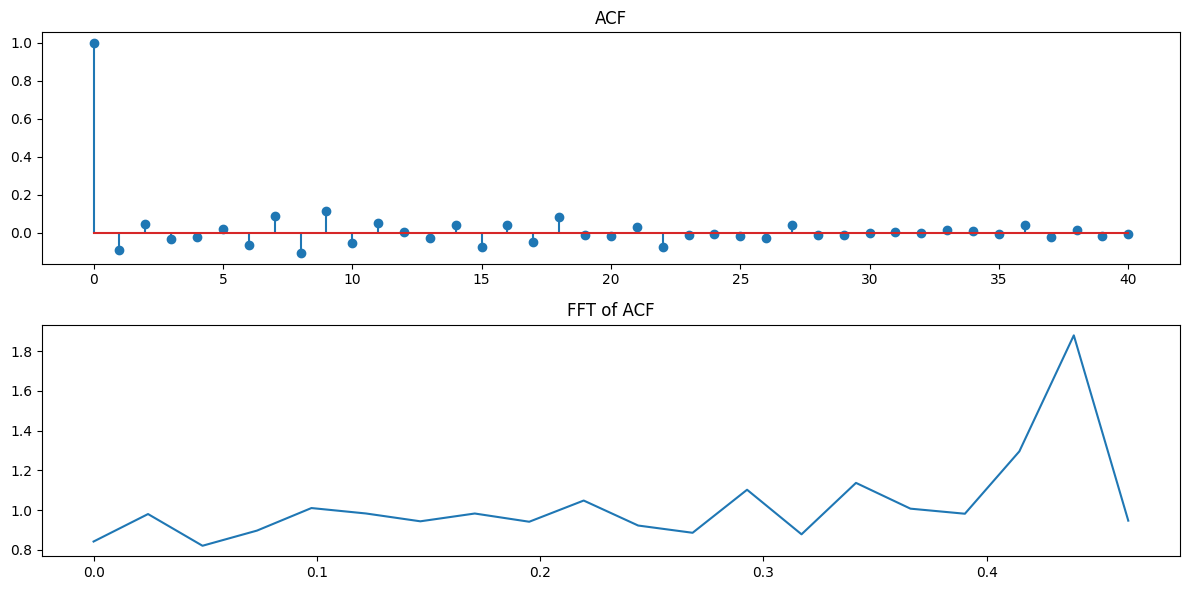

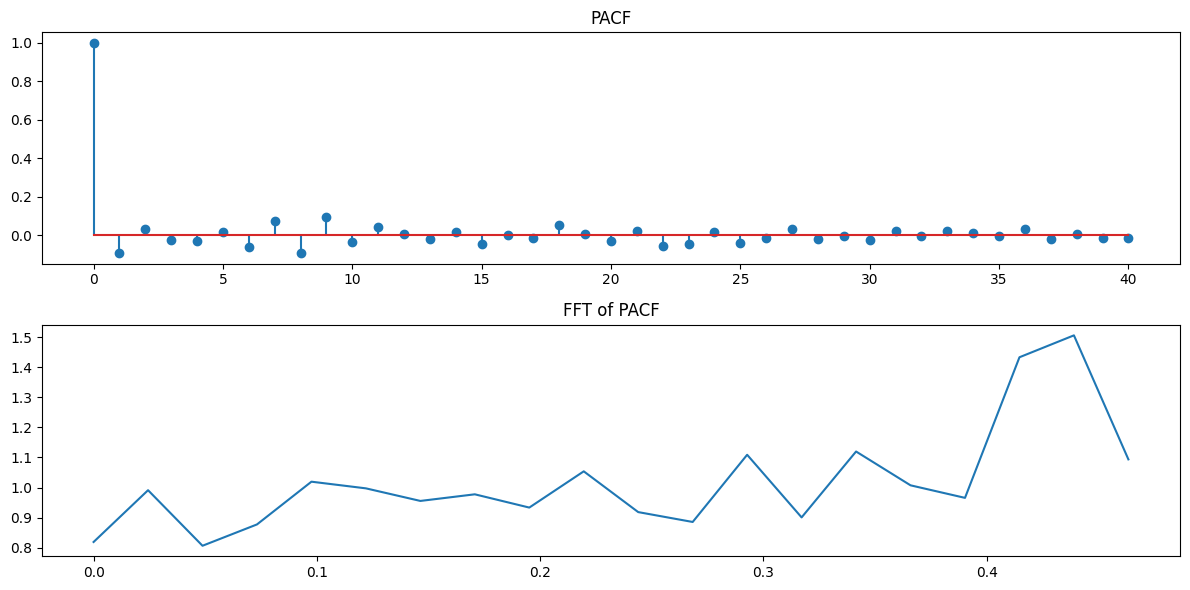

Dominant frequency: 0.0
Seasonal period: inf


<ipython-input-26-ecf4f2f85152>:64: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Seasonal period: {1 / dominant_frequency}")


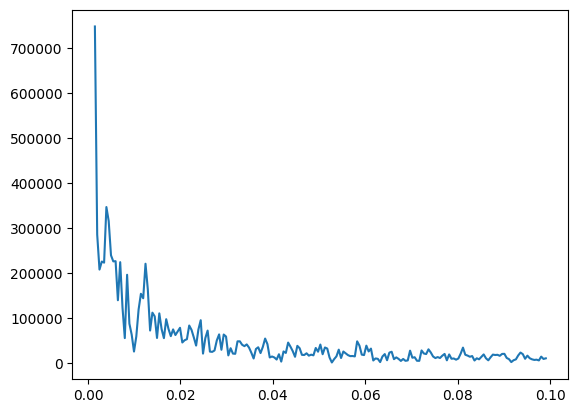

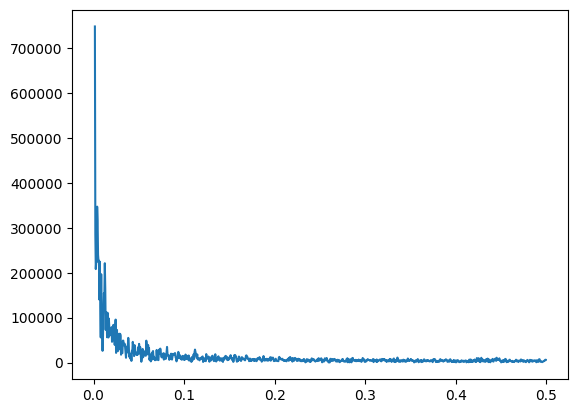

In [26]:
# Check for stationarity
adf_result = adfuller(close_prices)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
# If p-value > 0.05, the data is non-stationary, so differencing is needed:
differenced = close_prices.diff().dropna()
# Plot ACF and PACF
plot_acf(differenced)
plt.show()
plot_pacf(differenced)
plt.show()

from statsmodels.tsa.stattools import acf, pacf
from scipy.fft import fft, fftfreq

# Step 1: Compute ACF and PACF
acf_values = acf(differenced, nlags=40, fft=True)
pacf_values = pacf(differenced, nlags=40)

# Step 2: Compute FFT of ACF and PACF
acf_fft = fft(acf_values)
pacf_fft = fft(pacf_values)

# Frequencies for FFT
n = len(acf_fft)
frequencies = fftfreq(n)

# Step 3: Plot ACF and its FFT
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(range(len(acf_values)), acf_values)
plt.title('ACF')

plt.subplot(2, 1, 2)
plt.plot(frequencies[:n // 2], np.abs(acf_fft[:n // 2]))  # FFT Magnitude
plt.title('FFT of ACF')
plt.tight_layout()
plt.show()

# Step 4: Plot PACF and its FFT
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(range(len(pacf_values)), pacf_values)
plt.title('PACF')

plt.subplot(2, 1, 2)
plt.plot(frequencies[:n // 2], np.abs(pacf_fft[:n // 2]))  # FFT Magnitude
plt.title('FFT of PACF')
plt.tight_layout()
plt.show()

import numpy as np
from scipy.fft import fft

## Taking FFT to see check for seasonality in the data
# Apply Fourier Transform
fft_vals = fft(close_prices.to_numpy())
frequencies = np.fft.fftfreq(len(fft_vals))

# Find the dominant frequency
dominant_frequency = abs(frequencies[np.argmax(abs(fft_vals[1:]))])

print(f"Dominant frequency: {dominant_frequency}")
print(f"Seasonal period: {1 / dominant_frequency}")

plt.figure()
start_index = 3
plt.plot(frequencies[start_index:len(frequencies)//10], np.abs(fft_vals[start_index:len(fft_vals)//10]))
plt.show()
plt.figure()
start_index = 3
plt.plot(frequencies[start_index:len(frequencies)//2], np.abs(fft_vals[start_index:len(fft_vals)//2]))
plt.show()

In [ ]:
import copy

train_size = int(len(close_prices) * 0.8)
train = close_prices[:train_size]
test = close_prices[train_size:]
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

# Define ARIMA model parameters (p, d, q)
p = 1  # Number of AR terms
q = 1  # Number of MA terms
d = 1  # Time Differenced

# Make Predictions
start_index = train_size
end_index = len(close_prices) - 1
prediction_window = 5
window_size = 10

# Initialize a list to store predictions
predictions = []
actual_averages = []

# Copy the training data to use as the initial history
history = train.copy()

# Loop over each time point in the test set
for t in range(window_size, len(test) - prediction_window + 1):
    # Fit the ARIMA model on the current history
    train_window = test.iloc[t - window_size:t]

    # model = ARIMA(history, order=(p, d, q))
    model = SARIMAX(train_window, trend='c', order=(p, d, q))

    model_fit = model.fit()

    # Forecast the next 5 days
    forecast = model_fit.forecast(steps=prediction_window)
    predictions.append(forecast.mean())

    # Calculate actual average of the next 5 days
    actual_next_5 = test.iloc[t:t + prediction_window]
    actual_averages.append(actual_next_5.mean())

    # Append the actual observed value to the history
    history = pd.concat([history, test.iloc[t:t+1]])


model_nasdaq = copy.deepcopy(model)
# model_snp = copy.deepcopy(model)
# model_dow_jones = copy.deepcopy(model)

model_fit_nasdaq = copy.deepcopy(model_fit)
# model_fit_snp = copy.deepcopy(model_fit)
# model_fit_dow_jones = copy.deepcopy(model_fit)

predictions = pd.Series(predictions, index=test.index[window_size - 1 : -prediction_window])
# test.to_pickle("test.pkl")
# predictions.to_pickle("predictions_ARIMA.pkl")


predictions_nasdaq = copy.deepcopy(predictions)
# predictions_snp = copy.deepcopy(predictions)
# predictions_dow_jones = copy.deepcopy(predictions)

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices')
plt.plot(predictions.index, predictions, label='Predicted Prices')
plt.title('ARIMA Model Predictions')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/pyt

ValueError: Length of values (388) does not match length of index (402)

In [ ]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path = os.path.join(folder_path, "predictions_IXIC_1_1_1.pkl")
predictions_nasdaq.to_pickle(pickle_path)
pickle_path = os.path.join(folder_path, 'arima_model_IXIC_1_1_1.pkl')
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(model_fit_nasdaq, pkl_file)

Mounted at /content/drive


In [ ]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path = os.path.join(folder_path, "predictions_GSPC_1_1_1.pkl")
predictions_snp.to_pickle(pickle_path)
pickle_path = os.path.join(folder_path, 'arima_model_GSPC_1_1_1.pkl')
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(model_fit_snp, pkl_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path = os.path.join(folder_path, "predictions_DJI_1_1_1.pkl")
predictions_dow_jones.to_pickle(pickle_path)
pickle_path = os.path.join(folder_path, 'arima_model_DJI_1_1_1.pkl')
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(model_fit_dow_jones, pkl_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Unseen Data

In [4]:
# Step 1: Data Collection
nasdaq_unseen = yf.download('^IXIC', start="2023-01-01", end="2024-10-30")
SnP_unseen = yf.download('^GSPC', start="2023-01-01", end="2024-10-30")
DowJones_unseen = yf.download('^DJI', start="2023-01-01", end="2024-10-30")

# Flatten MultiIndex columns if present
if isinstance(nasdaq_unseen.columns, pd.MultiIndex):
    nasdaq_unseen.columns = ['_'.join(col).strip() for col in nasdaq_unseen.columns.values]
if isinstance(SnP_unseen.columns, pd.MultiIndex):
    SnP_unseen.columns = ['_'.join(col).strip() for col in SnP_unseen.columns.values]
if isinstance(DowJones_unseen.columns, pd.MultiIndex):
    DowJones_unseen.columns = ['_'.join(col).strip() for col in DowJones_unseen.columns.values]

# # Create binary target: 1 if next day's Close > today's Close, else 0
nasdaq_unseen['Target'] = nasdaq_unseen['Close_^IXIC'].rolling(window=5, min_periods=1).mean().shift(-5)
SnP_unseen['Target'] = SnP_unseen['Close_^GSPC'].rolling(window=5, min_periods=1).mean().shift(-5)
DowJones_unseen['Target'] = DowJones_unseen['Close_^DJI'].rolling(window=5, min_periods=1).mean().shift(-5)

# Drop rows with NaN values caused by rolling/shift operations
nasdaq_unseen.dropna(inplace=True)
SnP_unseen.dropna(inplace=True)
DowJones_unseen.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
import copy
from statsmodels.tsa.statespace.sarimax import SARIMAX
# close_prices = nasdaq_unseen['Close_^IXIC']
# close_prices = SnP_unseen['Close_^GSPC']
close_prices = DowJones_unseen['Close_^DJI']
test = close_prices

# Define ARIMA model parameters (p, d, q)
p = 1  # Number of AR terms
q = 1  # Number of MA terms
d = 1  # Time Differenced

# Make Predictions
start_index = 0
end_index = len(close_prices) - 1
prediction_window = 5
window_size = 10

# Initialize a list to store predictions
predictions = []
actual_averages = []

# Copy the training data to use as the initial history
train = test.copy()
history = train.copy()

# Loop over each time point in the test set
for t in range(window_size, len(test) - prediction_window + 1):
    # Fit the ARIMA model on the current history
    train_window = test.iloc[t - window_size:t]

    model = SARIMAX(train_window, trend='c', order=(p, d, q))

    model_fit = model.fit()

    # Forecast the next 5 days
    forecast = model_fit.forecast(steps=prediction_window)
    predictions.append(forecast.mean())

    # Calculate actual average of the next 5 days
    actual_next_5 = test.iloc[t:t + prediction_window]
    actual_averages.append(actual_next_5.mean())

    # Append the actual observed value to the history
    history = pd.concat([history, test.iloc[t:t+1]])


# model_nasdaq_unseen = copy.deepcopy(model)
# model_snp_unseen = copy.deepcopy(model)
model_dow_jones_unseen = copy.deepcopy(model)

# model_fit_nasdaq_unseen = copy.deepcopy(model_fit)
# model_fit_snp_unseen = copy.deepcopy(model_fit)
model_fit_dow_jones_unseen = copy.deepcopy(model_fit)

predictions = pd.Series(predictions, index=test.index[window_size - 1 : -prediction_window])

# predictions_nasdaq_unseen = copy.deepcopy(predictions)
# predictions_snp_unseen = copy.deepcopy(predictions)
predictions_dow_jones_unseen = copy.deepcopy(predictions)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [6]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path = os.path.join(folder_path, "predictions_IXIC_1_1_1_unseen.pkl")
predictions_nasdaq_unseen.to_pickle(pickle_path)
pickle_path = os.path.join(folder_path, 'arima_model_IXIC_1_1_1_unseen.pkl')
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(model_fit_nasdaq_unseen, pkl_file)

Mounted at /content/drive


In [14]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path = os.path.join(folder_path, "predictions_GSPC_1_1_1_unseen.pkl")
predictions_snp_unseen.to_pickle(pickle_path)
pickle_path = os.path.join(folder_path, 'arima_model_GSPC_1_1_1_unseen.pkl')
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(model_fit_snp_unseen, pkl_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path = os.path.join(folder_path, "predictions_DJI_1_1_1_unseen.pkl")
predictions_dow_jones_unseen.to_pickle(pickle_path)
pickle_path = os.path.join(folder_path, 'arima_model_DJI_1_1_1_unseen.pkl')
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(model_fit_dow_jones_unseen, pkl_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# # Evaluate predictions with additional metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def model_eval(test, predictions):

  mse = mean_squared_error(test, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test, predictions)
  mpe = np.mean(np. abs((test - predictions) / test)) * 100
  r2 = r2_score(test, predictions)
  print(f"Mean Squared Error: {mse:.4f}")
  rmse = np.sqrt(mse)
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Error: {mae:.4f}")
  print(f"Mean Percentage Error: {mpe:.4f}")
  print(f"R2 Score: {r2:.4f}")

  # Directional accuracy
  # Compute daily price changes
  test_diff = np.diff(test)  # Actual price changes
  predicted_diff = np.diff(predictions)  # Predicted price changes

  # Check directional agreement (sign of the differences)
  directional_accuracy = np.mean(np.sign(test_diff) == np.sign(predicted_diff)) * 100
  print(f"Directional Accuracy: {directional_accuracy:.4f}")

  maec = np.mean(np.abs(predicted_diff - test_diff))
  print(f"Mean Absolute Error of Change (MAEC): {maec:.2f}")

  # Visualize predictions vs actual
  plt.figure(figsize=(10, 6))
  plt.plot(predictions.index, test, label='Actual Average Price')
  plt.plot(predictions, label='Predicted Average Price')
  plt.legend()
  plt.title("Actual vs Predicted Average Price (Technical Indicators)")
  plt.show()

  # Absolute error plotting
  errors = test - predictions
  plt.figure(figsize=(10, 6))
  plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
  plt.title('Distribution of Prediction Errors')
  plt.xlabel('Error')
  plt.ylabel('Frequency')
  plt.show()

  # percentage error plotting
  errors = 100*(test - predictions)/test
  plt.figure(figsize=(10, 6))
  plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
  plt.title('Distribution of Prediction Errors in percentage')
  plt.xlabel('Error %')
  plt.ylabel('Frequency')
  plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Squared Error: 97015.0831
Root Mean Squared Error (RMSE): 311.4724
Mean Absolute Error: 245.6302
Mean Percentage Error: 1.6654
R2 Score: 0.9780
Directional Accuracy: 52.6196
Mean Absolute Error of Change (MAEC): 200.96


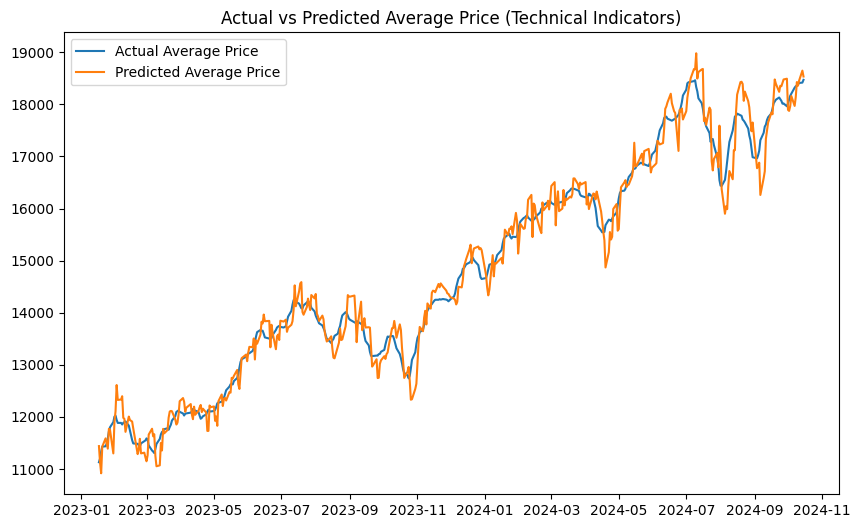

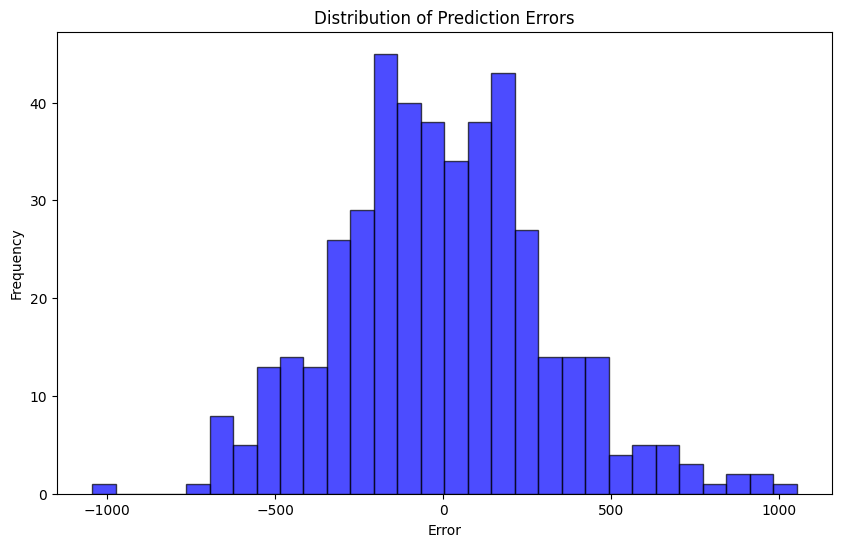

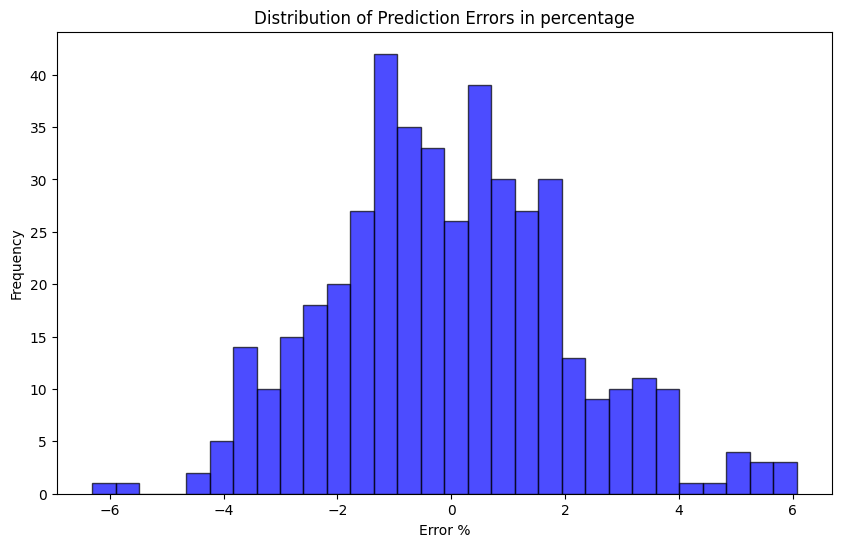

In [12]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path_predictions = os.path.join(folder_path, "predictions_IXIC_1_1_1_unseen.pkl")
predictions_nasdaq = pd.read_pickle(pickle_path_predictions)
# pickle_path_predictions = os.path.join(folder_path, "predictions_GSPC_1_1_1_unseen.pkl")
# predictions_snp = pd.read_pickle(pickle_path_predictions)
# pickle_path_predictions = os.path.join(folder_path, "predictions_DJI_1_1_1_unseen.pkl")
# predictions_dow_jones = pd.read_pickle(pickle_path_predictions)
# test = test[predictions_nasdaq.index]


test_data = nasdaq_unseen['Close_^IXIC']
actual_averages = []
for t in range(window_size, len(test_data) - prediction_window + 1):
    train_window = test_data.iloc[t - window_size:t]

    # Calculate actual average of the next 5 days
    actual_next_5 = test_data.iloc[t:t + prediction_window]
    actual_averages.append(actual_next_5.mean())
test = actual_averages

model_eval(test, predictions_nasdaq)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Squared Error: 5242.2244
Root Mean Squared Error (RMSE): 72.4032
Mean Absolute Error: 56.6692
Mean Percentage Error: 1.1975
R2 Score: 0.9832
Directional Accuracy: 50.7973
Mean Absolute Error of Change (MAEC): 46.52


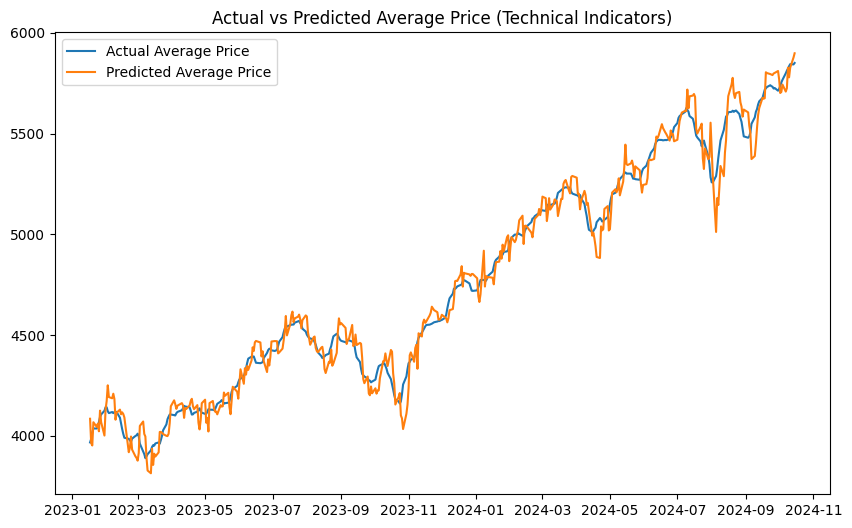

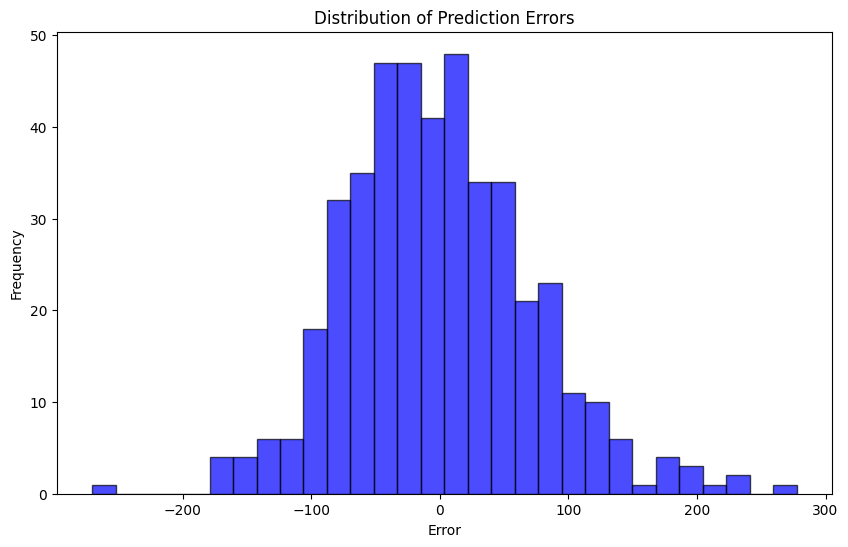

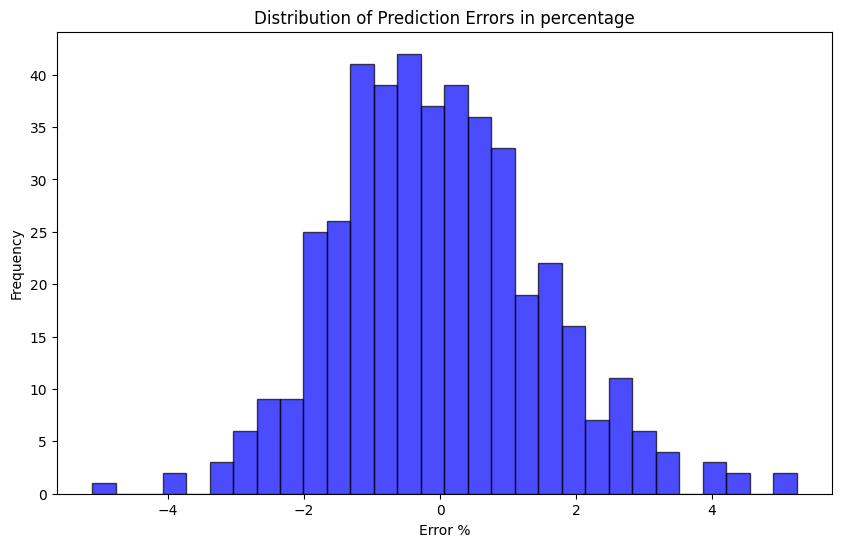

In [19]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path_predictions = os.path.join(folder_path, "predictions_GSPC_1_1_1_unseen.pkl")
predictions_snp = pd.read_pickle(pickle_path_predictions)

test_data = SnP_unseen['Close_^GSPC']
actual_averages = []
for t in range(window_size, len(test_data) - prediction_window + 1):
    train_window = test_data.iloc[t - window_size:t]

    # Calculate actual average of the next 5 days
    actual_next_5 = test_data.iloc[t:t + prediction_window]
    actual_averages.append(actual_next_5.mean())
test = actual_averages

model_eval(test, predictions_snp)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Squared Error: 248248.1469
Root Mean Squared Error (RMSE): 498.2451
Mean Absolute Error: 388.1206
Mean Percentage Error: 1.0627
R2 Score: 0.9720
Directional Accuracy: 52.6196
Mean Absolute Error of Change (MAEC): 313.87


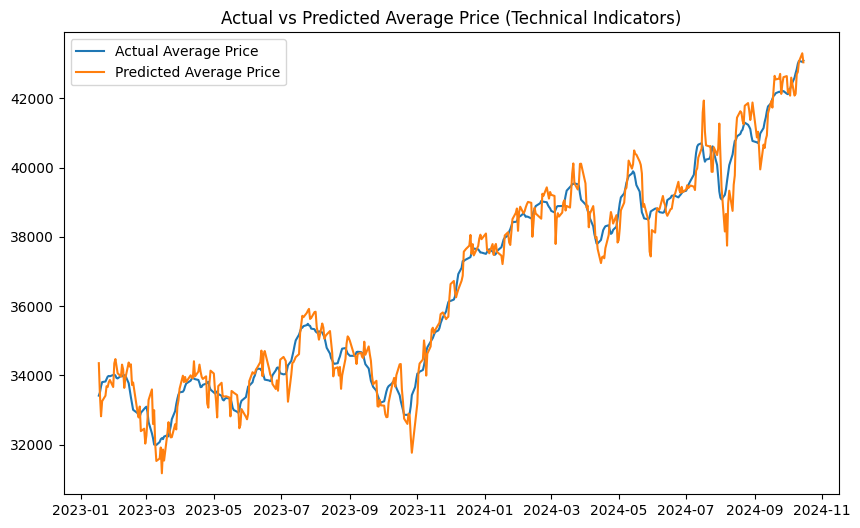

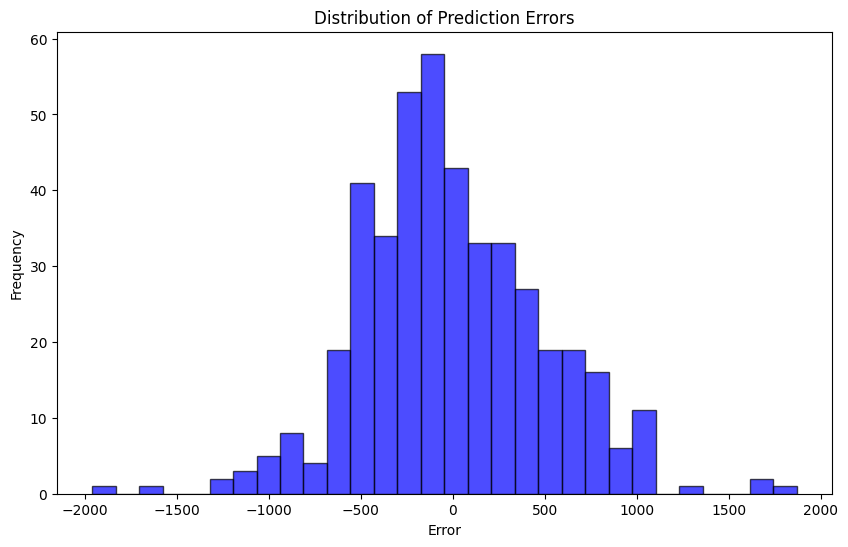

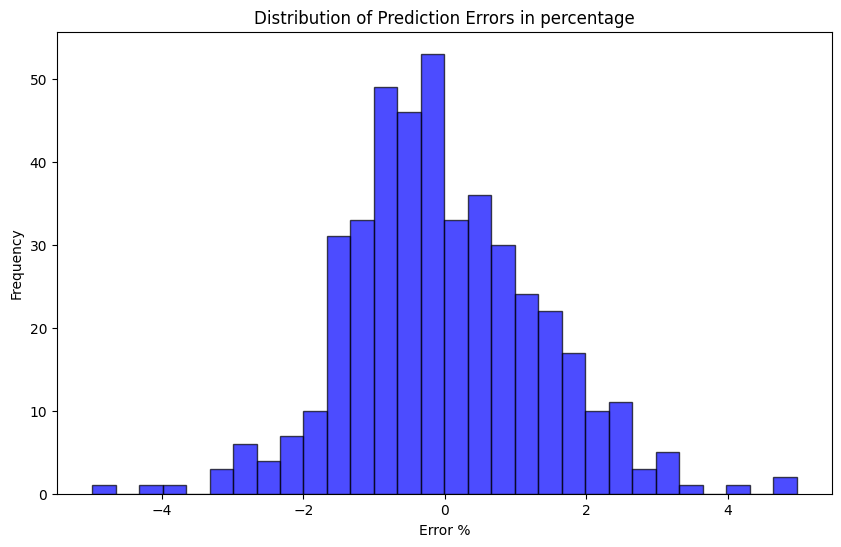

In [20]:
import os
from google.colab import drive
import pickle
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/AppliedMLProject'
os.makedirs(folder_path, exist_ok=True)
pickle_path_predictions = os.path.join(folder_path, "predictions_DJI_1_1_1_unseen.pkl")
predictions_dow_jones = pd.read_pickle(pickle_path_predictions)

test_data = DowJones_unseen['Close_^DJI']
actual_averages = []
for t in range(window_size, len(test_data) - prediction_window + 1):
    train_window = test_data.iloc[t - window_size:t]

    # Calculate actual average of the next 5 days
    actual_next_5 = test_data.iloc[t:t + prediction_window]
    actual_averages.append(actual_next_5.mean())
test = actual_averages

model_eval(test, predictions_dow_jones)